In [1]:
import cv2

from ximea import xiapi
from constants import XimeaParams

class XiCamDriver(XimeaParams):
    # Third parameter is for stereo vision,
    # it's boolean and means master (if True),
    # slave (if False) or single camera (if None).
    #
    # Example URL syntax:
    # - `file:///full/path/to/local/file.yaml`
    # - `package://ros_package_name/calibrations/camera.yaml`
    #
    # The `file:` URL specifies a full path name in the local system.
    # The `package:` URL is handled the same as `file:`, except the path
    # name is resolved relative to the location of the named ROS
    # package, which must be reachable via `$ROS_PACKAGE_PATH`.
    # TODO @maxtar move strings to the constants class
    def __init__(self, serial_number, master="None"):

        self.cam = xiapi.Camera()
        self.img = xiapi.Image()
        self.master = master
        self._init_camera(serial_number)
        self.serial_number = serial_number

    def _init_camera(self, serial_number):
        self.cam.open_device_by_SN(serial_number)
        self._set_params()

    def start(self):
        self.cam.start_acquisition()

    def publish(self):

        self.get_image()
        image_data_numpy = self.img.get_image_data_numpy()
        np.save("./images/image" + str(self.serial_number), image_data_numpy)
    def _set_params(self,
                    img_data_format=XimeaParams.IMG_DATA_FORMAT,
                    exposure=XimeaParams.EXPOSURE,
                    gain=XimeaParams.GAIN,
                    downsampling_type=XimeaParams.DOWNSAMPLING_TYPE,
                    downsampling_rate=XimeaParams.DOWNSAMPLING_RATE):
        self.cam.set_imgdataformat(img_data_format)
        self.cam.set_exposure(exposure)
        self.cam.set_gain(gain)

        self.cam.set_downsampling_type("XI_" + downsampling_type)
        self.cam.set_downsampling("XI_DWN_" + downsampling_rate)

    def get_image(self):
        self.cam.get_image(self.img)
        # print("\nIMG_TIMESTAMP: " + str(self.img.tsSec) + "." + str(self.img.tsUSec) + "\n")
        # print("\nCAM_TIMESTAMP: " + str(self.cam.get_timestamp()) + "\n")
        return

    def trig(self):
        self.cam.set_trigger_software(1)

    def stop(self):
        self.cam.stop_acquisition()
        self.cam.close_device()

In [2]:
import time
#import 
# from utils.constants import XimeaParams
#from xicamdriver import XiCamDriver


class StereoXiCamDriver:
    def __init__(self, left_serial_number, left_is_master,
                 right_serial_number, right_is_master, namespace="/stereo"):
        self.l_cam = XiCamDriver(serial_number=left_serial_number,
                                 master=left_is_master)
        self.r_cam = XiCamDriver(serial_number=right_serial_number,
                                 master=right_is_master)
        self.cams = self.l_cam, self.r_cam
        # TODO @maxtar how to remove this sleep time?
        time.sleep(2)
        self.make_stereo()
        for cam in self.cams:
            cam.start()

    def trig(self):
        for cam in self.cams:
            if cam.master is True:
                cam.trig()

    def make_stereo(self):
        master_is_set = False
        slave_is_set = False
        assert (len(self.cams) == 2), "There must be strictly two cameras."
        for cam in self.cams:
            if cam.master is True and master_is_set is False:
                cam.cam.set_trigger_source("XI_TRG_SOFTWARE")
                cam.cam.set_gpo_selector("XI_GPO_PORT1")
                cam.cam.set_gpo_mode("XI_GPO_FRAME_ACTIVE_NEG")  # XI_GPO_FRAME_ACTIVE_NEG / XI_GPO_EXPOSURE_ACTIVE
            elif cam.master is False and slave_is_set is False:
                cam.cam.set_trigger_source("XI_TRG_EDGE_RISING")
                cam.cam.set_gpi_selector("XI_GPI_PORT2")
                cam.cam.set_gpi_mode("XI_GPI_TRIGGER")
            elif (cam.master is True & master_is_set is True) or \
                    (cam.master is False & slave_is_set is True):
                raise Exception("One of the cameras must be a master and the other a slave.")
        time.sleep(2)

    def publish(self):
        for cam in self.cams:
            cam.publish()

    def stop(self):
        for cam in self.cams:
            cam.stop()

In [3]:
stereocam = StereoXiCamDriver(left_serial_number = "25797059", left_is_master = True,
                 right_serial_number = "25791059" , right_is_master = False)


In [4]:
stereocam.publish()

Xi_error: ERROR 10: Timeout

In [ ]:
stereocam.stop()

In [17]:
from ximea import xiapi
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [18]:
class camera_ximea:
    def __init__(self, number):
        self.number = number
        self.cam = xiapi.Camera()
        self.img = xiapi.Image()
        
    def open_device(self):
        self.cam.open_device_by_SN(self.number)
        #print('Opening camera: ' + self.number)
        
    def set_exp(self):
        self.cam.set_exposure(10000)
        
    def start_asq(self):
        self.cam.start_acquisition()
        #print('Starting data acquisition...')
        
    def save_image(self, name_image):
        self.cam.get_image(self.img)
        data_numpy = self.img.get_image_data_numpy()
        im = Image.fromarray(data_numpy)
        line = "./images_for_stereocalibration/"+ self.number + "/"
        im.save(line + name_image + ".png")
        #print('Image number: ' + str(i))
        #print('Image width (pixels):  ' + str(img.width))
        #print('Image height (pixels): ' + str(img.height))
        #print('First 10 pixels: ' + str(data[:10]))
        #print('\n')
        
    def get_image(self):
        self.cam.get_image(self.img)
        data_numpy = self.img.get_image_data_numpy()
        im = Image.fromarray(data_numpy)
        return im
    
    def make_photo(self, name_image):
        self.open_device()
        self.set_exp()
        self.start_asq()
        self.save_image(name_image)
        self.stop_asq()
        self.close_device()
        
    def stop_asq(self):
        self.cam.stop_acquisition()
        #print('Stopping acquisition...')
        
    def close_device(self):
        self.cam.close_device()
        print('Done.')
    
    def show_me(self):
        self.open_device()
        self.set_exp()
        self.start_asq()
        plt.imshow(self.get_image())
        plt.show()
        self.stop_asq()
        self.close_device()
        
    def start_cam(self):
        self.open_device()
        self.set_exp()
        self.start_asq()
        
    def stop_cam(self):
        self.stop_asq()
        self.close_device()
        

In [19]:
class double_cam:
    def __init__(self, left_cam_number, right_cam_number):
        self.left_cam = camera_ximea(name_left)
        self.right_cam = camera_ximea(name_right)
        
    def make_double_photo(self, name_left_photo, name_right_photo):
        self.left_cam.make_photo(name_left_photo)
        self.right_cam.make_photo(name_right_photo)
    def quick_get_image(self):
        return (self.left_cam.get_image(), self.right_cam.get_image())
    
    def quick_save_image(self, name_left_photo, name_right_photo):
        self.left_cam.save_image(name_left_photo)
        self.rgiht_cam.save_image(name_right_photo)
        
    def start_cams(self):
        self.left_cam.start_cam()
        self.right_cam.start_cam()
        
    def stop_cams(self):
        self.left_cam.stop_cam()
        self.right_cam.stop_cam()

In [20]:
name_left = "25797059"
name_right = "25791059"
d_c = double_cam(name_left, name_right)

In [21]:
#d_c.make_double_photo("1", "1")

In [24]:
d_c.start_cams()

Xi_error: ERROR 10: Timeout

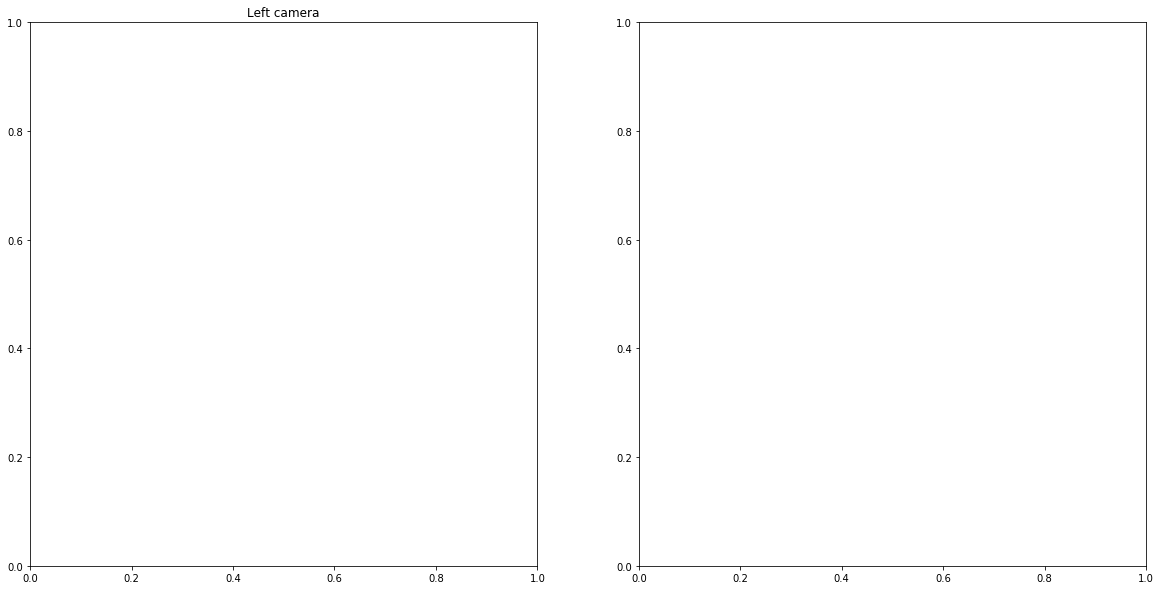

In [25]:
fx, plots = plt.subplots(1, 2, figsize=(20,10))
clear_output()
plots[0].set_title("Left camera")
plots[0].imshow(d_c.quick_get_image()[0])

plots[1].set_title("Right camera")
plots[1].imshow(d_c.quick_get_image()[1])

In [ ]:
d_c.stop_cams()